In [2]:
import openmc
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import utils as u

PROJECT_ROOT = Path("../..").resolve()
RUNS_DIR = PROJECT_ROOT / "02_simulation" / "runs" / "ex_01_moderation_fraction"
run_dirs = sorted(RUNS_DIR.glob("run_*"))

In [3]:
statepoints = []
for run_dir in run_dirs:
    statepoints.append(openmc.StatePoint(u.find_statepoint(run_dir)))

In [4]:
sp = statepoints[0]

In [33]:
phi_Es = []

thermal_flux_fractions = []
epithermal_flux_fractions = []
fast_flux_fractions = []
flux_probs = []

fission_Es = []
fission_probs = []
avg_fission_energies = []

keffs = []
keff_errors = []

fuel_radii = [0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.40, 0.41, 0.42, 0.43, 0.44, 0.45, 0.46]

for sp in statepoints:

    # Fuel flux spectrum analysis
    fuel_flux = sp.get_tally(name="fuel_flux_spectrum")

    fuel_flux_vals = fuel_flux.mean.flatten()
    fuel_flux_std = fuel_flux.std_dev.flatten()

    energy_filter = fuel_flux.find_filter(openmc.EnergyFilter)
    energy_bins = np.unique(energy_filter.bins)
    bin_widths = energy_bins[1:] - energy_bins[:-1]

    bin_widths = energy_bins[1:] - energy_bins[:-1]
    phi_E = fuel_flux_vals / bin_widths
    phi_Es.append(phi_E)

    bin_centers = 0.5 * (energy_bins[:-1] + energy_bins[1:])

    # Flux fraction masks
    E_THERMAL = 0.625  # eV
    thermal_mask = bin_centers < E_THERMAL

    E_EPITHERMAL = 100000 # eV
    epithermal_mask = (
        (bin_centers >= E_THERMAL) &
        (bin_centers < E_EPITHERMAL)
    )

    fast_mask = bin_centers > E_EPITHERMAL

    thermal_flux = np.sum(phi_E[thermal_mask] * bin_widths[thermal_mask])
    epithermal_flux = np.sum(phi_E[epithermal_mask] * bin_widths[epithermal_mask])
    fast_flux = np.sum(phi_E[fast_mask] * bin_widths[fast_mask])

    total_flux = np.sum(phi_E * bin_widths)

    thermal_flux_fraction = thermal_flux / total_flux
    epithermal_flux_fraction = epithermal_flux / total_flux
    fast_flux_fraction = fast_flux / total_flux

    thermal_flux_fractions.append(thermal_flux_fraction)
    epithermal_flux_fractions.append(epithermal_flux_fraction)
    fast_flux_fractions.append(fast_flux_fraction)

    flux_prob = fuel_flux_vals / fuel_flux_vals.sum()
    flux_probs.append(flux_prob)

    # Fission energy
    fission = sp.get_tally(name="fission_energy")
    fission_vals = fission.mean.flatten()

    fission_E = fission_vals / bin_centers
    fission_Es.append(fission_E)

    fission_prob = fission_vals / fission_vals.sum()
    fission_probs.append(fission_prob)

    avg_fission_energy = np.sum(bin_centers * fission_vals) / np.sum(fission_vals)
    avg_fission_energies.append(avg_fission_energy)

    # keff
    keffs.append(float(sp.keff.n))
    keff_errors.append(float(sp.keff.s))

assert np.isclose(
    thermal_flux_fraction +
    epithermal_flux_fraction +
    fast_flux_fraction,
    1.0,
    rtol=1e-3
)

assert fuel_flux_vals.shape == bin_centers.shape



/home/ethan/miniconda3/envs/reactor-opt/lib/python3.11/site-packages/uncertainties/core.py:526: FutureWarning: Variable.error_components() is currently an instance method. This method is deprecated. In a future release it will be replaced with an instance property by the same name. It will be accessed by Variable.error_components (with no parentheses).
  return float(sqrt(sum(delta**2 for delta in self.error_components().values())))
/home/ethan/miniconda3/envs/reactor-opt/lib/python3.11/site-packages/uncertainties/core.py:491: FutureWarning: Variable.derivatives() is deprecated. It will be removed in a future release.
  for variable, derivative in self.derivatives.items():


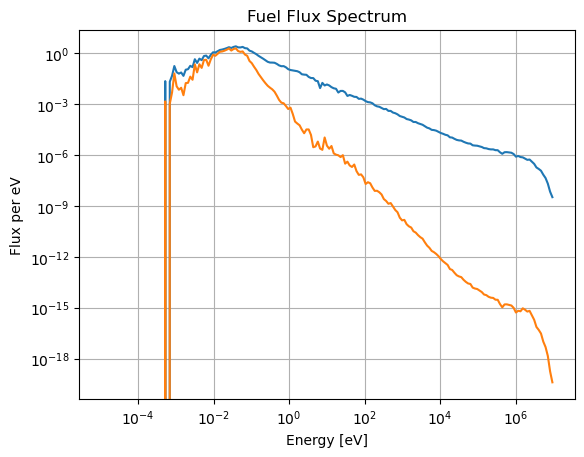

In [ ]:
plt.figure()
plt.loglog(bin_centers, phi_Es[0])
plt.loglog(bin_centers, fission_Es[0] * phi_Es[0])
plt.xlabel("Energy [eV]")
plt.ylabel("Flux per eV")
plt.title("Fuel Flux Spectrum")
plt.grid(True)

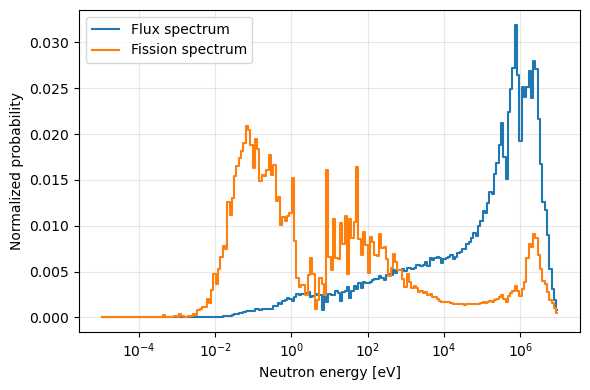

In [34]:
plt.figure(figsize=(6,4))

plt.step(bin_centers, flux_prob, where="mid", label="Flux spectrum")
plt.step(bin_centers, fission_prob, where="mid", label="Fission spectrum")

plt.xscale("log")
plt.xlabel("Neutron energy [eV]")
plt.ylabel("Normalized probability")
plt.grid(True, which="both", alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


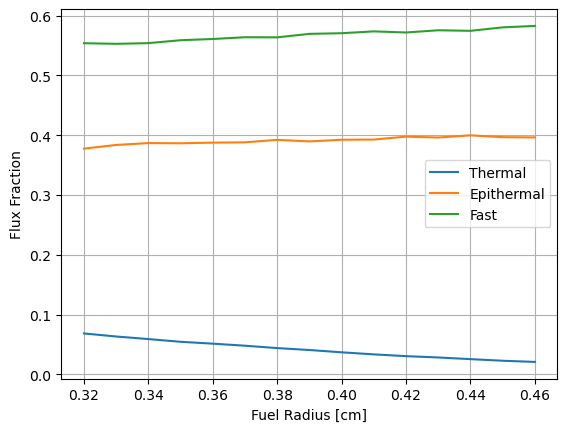

In [22]:
plt.figure()
plt.plot(fuel_radii, thermal_flux_fractions, label="Thermal")
plt.plot(fuel_radii, epithermal_flux_fractions, label="Epithermal")
plt.plot(fuel_radii, fast_flux_fractions, label='Fast')
plt.legend()
plt.xlabel("Fuel Radius [cm]")
plt.ylabel("Flux Fraction")
plt.grid(True)

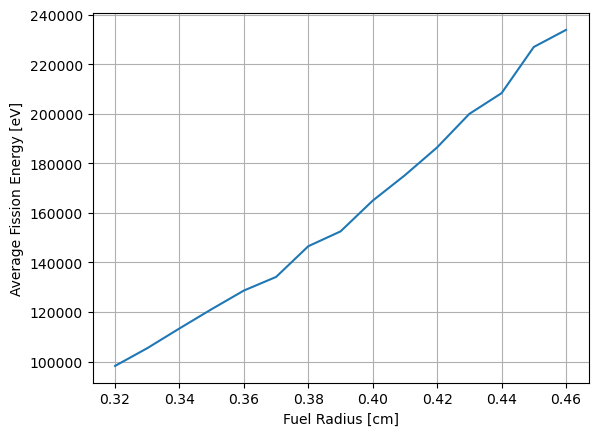

In [24]:
plt.figure()
plt.plot(fuel_radii, avg_fission_energies)
plt.xlabel("Fuel Radius [cm]")
plt.ylabel("Average Fission Energy [eV]")
plt.grid(True)

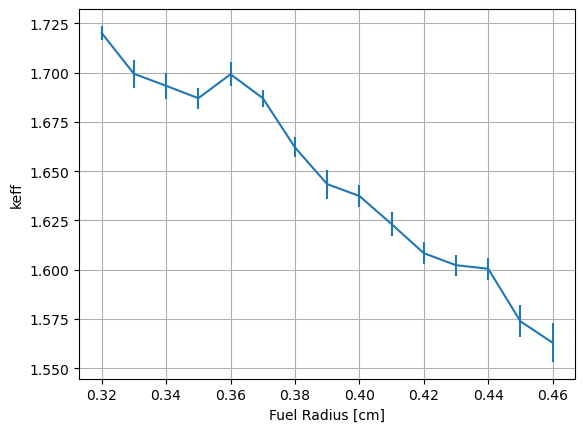

In [9]:
plt.figure()
plt.errorbar(fuel_radii, keffs, keff_errors)
plt.xlabel("Fuel Radius [cm]")
plt.ylabel("keff")
plt.grid(True)